In [47]:
# Import library
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from phreeqpy.iphreeqc.phreeqc_dll import IPhreeqc  # type: ignore

In [48]:
# Create an instance of Iphreeqc
iphreeqc = IPhreeqc()

# Load the Phreeqc database
database_path = "/usr/local/share/doc/IPhreeqc/database/llnl.dat"
print(f"Trying to load the PHREEQC database: {database_path}")
try:
    iphreeqc.load_database(database_path)
    print("Successfully Loaded the PHREEQC database")
except Exception as e:
    print("Failed to Load the PHREEQC database:", e)
    exit(1)

Trying to load the PHREEQC database: /usr/local/share/doc/IPhreeqc/database/llnl.dat
Successfully Loaded the PHREEQC database


In [49]:
# Define input data

Na_molar_mass = 22.9898
Cl_molar_mass = 35.453
Ca_molar_mass = 40.078
K_molar_mass = 39.0983
Mg_molar_mass = 24.305
Si_molar_mass = 28.0855
SO4_molar_mass = 96.06
HCO3_molar_mass = 61.016

pH_input = 8.5
temp_input = 25  # Celcius
Na_input = 8.94  # ppm
Cl_input = 10  # ppm
Ca_input = 25.6  # ppm
K_input = 1.71  # ppm
Mg_input = 8.10  # ppm
Si_input = 4.50  # ppm
SO4_input = 21.1  # ppm
ALK_input = 1.64 # meg/L
Lake_volume = 2.335e+12 # L
River_inflow = 2.6e+11 # L/yr
Simulation_time = 10000 # years

current_input = {
    "pH": pH_input,
    "Na+": Na_input / Na_molar_mass,  # Convert to mmol/kgw
    "Cl-": Cl_input / Cl_molar_mass,  # Convert to mmol/kgw
    "Ca+2": Ca_input / Ca_molar_mass,  # Convert to mmol/kgw
    "K+": K_input / K_molar_mass,  # Convert to mmol/kgw
    "Mg+2": Mg_input / Mg_molar_mass,  # Convert to mmol/kgw
    "Si": Si_input / Si_molar_mass,  # Convert to mmol/kgw
    "SO4-2": SO4_input / SO4_molar_mass,  # Convert to mmol/kgw
    "ALK": ALK_input, # mmol/kgw
    'Temp': temp_input, # Celcius
    'Fugacity': 0, # CO2 Fugacity
    'MHC': 0,
    'AMC': 0,
    'MSH': 0
}

In [50]:
# Fugacity calculation
fug_calc = f"""

SOLUTION 1 # Lake water
    pH      {current_input['pH']}
    temp    {current_input['Temp']} # degrees Celsius
    -water  1 # kg
    density 1.0 # g/cm^3
    units   mmol/kgw
    Na      {current_input['Na+']} 
    Ca      {current_input['Ca+2']}
    K       {current_input['K+']}
    Mg      {current_input['Mg+2']}
    Si      {current_input['Si']}
    S(6)    {current_input['SO4-2']}
    Cl      {current_input['Cl-']} charge
    Alkalinity {current_input['ALK']} as HCO3

SELECTED_OUTPUT
    -file                 false
    -high_precision       false
    -reset                false
    -step                 false
    -pH                   false
    -alkalinity           false
    -water                false
    -saturation_indices   CO2(g)

"""

# Run the PHREEQC
print("Calculating fugacity...")
try:
    iphreeqc.run_string(fug_calc)
except Exception as e:
    print("Failed to execute PHREEQC:", e)

fug_output = iphreeqc.get_selected_output_array()
fug_str = fug_output[1][0]
current_input['Fugacity'] = float(fug_str)

Calculating fugacity...


In [51]:
# Evaporation simulation
phreeqc_input = f"""

SOLUTION 1 # Lake water
    pH      {current_input['pH']}
    temp    {current_input['Temp']} # degrees Celsius
    -water  1 # kg
    density 1.0 # g/cm^3
    units   mmol/kgw
    Na      {current_input['Na+']} 
    Ca      {current_input['Ca+2']}
    K       {current_input['K+']}
    Mg      {current_input['Mg+2']}
    Si      {current_input['Si']}
    S(6)    {current_input['SO4-2']}
    Cl      {current_input['Cl-']} charge
    Alkalinity {current_input['ALK']} as HCO3

PHASES
Monohydrocalcite
    CaCO3:H2O + H+ = Ca+2 + H2O + HCO3-
    log_k     3.1488
AMC_TK
    MgCO3:3H2O + H+ = 3H2O + HCO3- + Mg+2
    log_k     4.7388
MSH075KF
    Mg0.75SiO4H2.5 + 1.5H+ = 2H2O + SiO2 + 0.75Mg+2
    log_k     6.841

REACTION 1 # Evaporation of inflow water
    H2O        -1
    55.505 moles in 10000 steps

EQUILIBRIUM_PHASES 1
    CO2(g)    {current_input['Fugacity']} 10
    Monohydrocalcite 0 0
    AMC_TK    0 0
    MSH075KF  0 0

SELECTED_OUTPUT
    -file                 false
    -high_precision       false
    -reset                true
    -step                 true
    -pH                   true
    -alkalinity           true
    -water                true
    -totals               Na  Ca  S(6)  C(4) K Si Mg Cl
    -equilibrium_phases   AMC_TK  Monohydrocalcite  MSH075KF
    -saturation_indices   AMC_TK  Monohydrocalcite  MSH075KF
    -activities           Na+ Ca+2 K+ Mg+2 HCO3- Cl- SO4-2 Si
    -molalities           Na+ Ca+2 K+ Mg+2 HCO3- Cl- SO4-2 Si
    -gases                CO2(g)

"""

In [52]:
# Result

result = []

# Loop
for i in range(0, Simulation_time):

    # Evaporation simulation
    evap_calc = f"""

    PHASES
    Monohydrocalcite
        CaCO3:H2O + H+ = Ca+2 + H2O + HCO3-
        log_k     3.1488
    AMC_TK
        MgCO3:3H2O + H+ = 3H2O + HCO3- + Mg+2
        log_k     4.7388
    MSH075KF
        Mg0.75SiO4H2.5 + 1.5H+ = 2H2O + SiO2 + 0.75Mg+2
        log_k     6.841

    SOLUTION 1 # Lake water
        pH      {current_input['pH']}
        temp    {current_input['Temp']} # degrees Celsius
        -water  1 # kg
        density 1.0 # g/cm^3
        units   mmol/kgw
        Na      {current_input['Na+']} 
        Ca      {current_input['Ca+2']}
        K       {current_input['K+']}
        Mg      {current_input['Mg+2']}
        Si      {current_input['Si']}
        S(6)    {current_input['SO4-2']}
        Cl      {current_input['Cl-']} charge
        Alkalinity {current_input['ALK']} as HCO3

    SOLUTION 2 # River water
        pH      {pH_input}
        temp    {temp_input} # degrees Celsius
        -water  {River_inflow / Lake_volume} # kg
        density 1.0 # g/cm^3
        units   mmol/kgw
        Na      {Na_input / Na_molar_mass} 
        Ca      {Ca_input / Ca_molar_mass}
        K       {K_input / K_molar_mass}
        Mg      {Mg_input / Mg_molar_mass}
        Si      {Si_input / Si_molar_mass}
        S(6)    {SO4_input / SO4_molar_mass}
        Cl      {Cl_input / Cl_molar_mass} charge
        Alkalinity {ALK_input} as HCO3

    MIX 3
        1   1
        2   1

    REACTION 3 # Evaporation of inflow water
        H2O        -1
        {River_inflow * 55.525397 / Lake_volume} moles in 1 steps

    EQUILIBRIUM_PHASES 3
        CO2(g)    {current_input['Fugacity']} 10
        Monohydrocalcite 0 {current_input['MHC']}
        AMC_TK    0 {current_input['AMC']}
        MSH075KF  0 {current_input['MSH']}

    SELECTED_OUTPUT
        -file                 false
        -high_precision       false
        -reset                true
        -step                 false
        -pH                   true
        -state                false
        -time                 false
        -reaction             false
        -simulation           false
        -solution             false
        -alkalinity           true
        -water                true
        -totals               Na  Ca  S(6)  C(4) K Si Mg Cl
        -equilibrium_phases   AMC_TK  Monohydrocalcite  MSH075KF
        -saturation_indices   AMC_TK  Monohydrocalcite  MSH075KF
        -activities           Na+ Ca+2 K+ Mg+2 HCO3- Cl- SO4-2 Si
        -molalities           Na+ Ca+2 K+ Mg+2 HCO3- Cl- SO4-2 Si
        -gases                CO2(g)

    """

    # Run the PHREEQC
    print("Simulation (",i,"/",Simulation_time,")")
    try:
        iphreeqc.run_string(evap_calc)
    except Exception as e:
        print("Failed to execute PHREEQC:", e)

    # Output
    evap_output = iphreeqc.get_selected_output_array()
    evap_header = ['time', *evap_output[0]]
    evap_result = [i + 1, *evap_output[-1]]
    result.append(evap_result)

    # Result feedback
    values = dict(zip(evap_header, evap_result))
    current_input['Na+'] = values.get("Na(mol/kgw)") * 1000
    current_input["Cl-"] = values.get("Cl(mol/kgw)") * 1000
    current_input["Ca+2"] = values.get("Ca(mol/kgw)") * 1000
    current_input["K+"] = values.get("K(mol/kgw)") * 1000
    current_input["Mg+2"] = values.get("Mg(mol/kgw)") * 1000
    current_input["Si"] = values.get("Si(mol/kgw)") * 1000
    current_input["SO4-2"] = values.get("S(6)(mol/kgw)") * 1000
    current_input["ALK"] = values.get("Alk(eq/kgw)") * 1000
    current_input["pH"] = values.get("pH")
    current_input["MHC"] = values.get("Monohydrocalcite")
    current_input["MSH"] = values.get("MSH075KF")
    current_input["AMC"] = values.get("AMC_TK")


Simulation ( 0 / 10000 )
Simulation ( 1 / 10000 )
Simulation ( 2 / 10000 )
Simulation ( 3 / 10000 )


Simulation ( 4 / 10000 )
Simulation ( 5 / 10000 )
Simulation ( 6 / 10000 )
Simulation ( 7 / 10000 )
Simulation ( 8 / 10000 )
Simulation ( 9 / 10000 )
Simulation ( 10 / 10000 )
Simulation ( 11 / 10000 )
Simulation ( 12 / 10000 )
Simulation ( 13 / 10000 )
Simulation ( 14 / 10000 )
Simulation ( 15 / 10000 )
Simulation ( 16 / 10000 )
Simulation ( 17 / 10000 )
Simulation ( 18 / 10000 )
Simulation ( 19 / 10000 )
Simulation ( 20 / 10000 )
Simulation ( 21 / 10000 )
Simulation ( 22 / 10000 )
Simulation ( 23 / 10000 )
Simulation ( 24 / 10000 )
Simulation ( 25 / 10000 )
Simulation ( 26 / 10000 )
Simulation ( 27 / 10000 )
Simulation ( 28 / 10000 )
Simulation ( 29 / 10000 )
Simulation ( 30 / 10000 )
Simulation ( 31 / 10000 )
Simulation ( 32 / 10000 )
Simulation ( 33 / 10000 )
Simulation ( 34 / 10000 )
Simulation ( 35 / 10000 )
Simulation ( 36 / 10000 )
Simulation ( 37 / 10000 )
Simulation ( 38 / 10000 )
Simulation ( 39 / 10000 )
Simulation ( 40 / 10000 )
Simulation ( 41 / 10000 )
Simulation ( 42 / 

<Figure size 640x480 with 0 Axes>

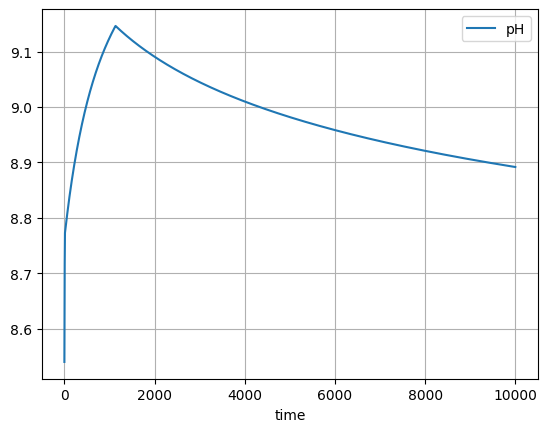

<Figure size 640x480 with 0 Axes>

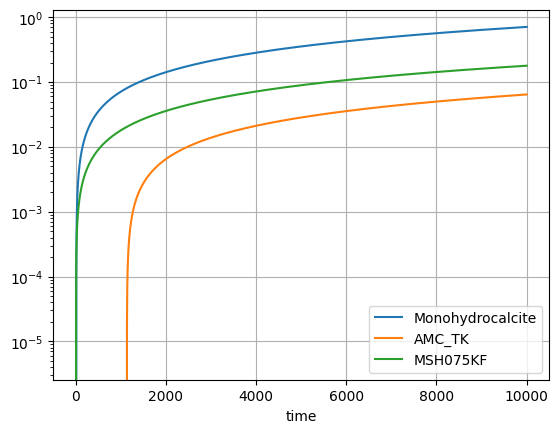

<Figure size 640x480 with 0 Axes>

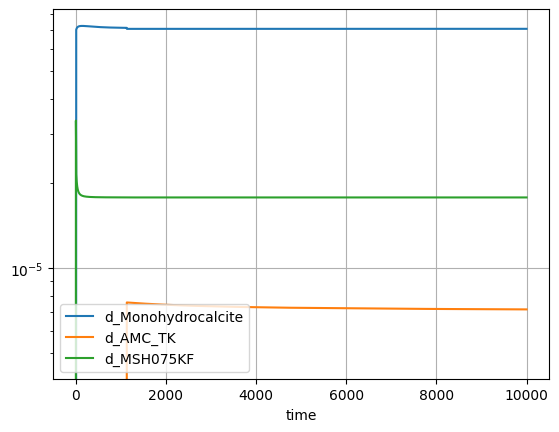

<Figure size 640x480 with 0 Axes>

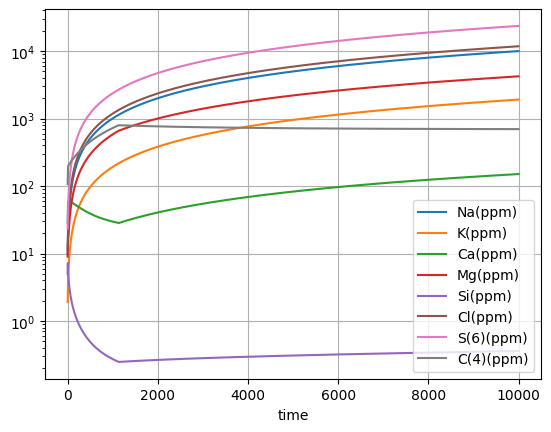

In [57]:
# Create data frame
evap_df = pd.DataFrame(result, columns=evap_header)
evap_df['Na(ppm)'] = evap_df['Na(mol/kgw)'] * 1000 * Na_molar_mass
evap_df['Cl(ppm)'] = evap_df['Cl(mol/kgw)'] * 1000 * Cl_molar_mass
evap_df['S(6)(ppm)'] = evap_df['S(6)(mol/kgw)'] * 1000 * SO4_molar_mass
evap_df['C(4)(ppm)'] = evap_df['C(4)(mol/kgw)'] * 1000 * HCO3_molar_mass
evap_df['K(ppm)'] = evap_df['K(mol/kgw)'] * 1000 * K_molar_mass
evap_df['Ca(ppm)'] = evap_df['Ca(mol/kgw)'] * 1000 * Ca_molar_mass
evap_df['Mg(ppm)'] = evap_df['Mg(mol/kgw)'] * 1000 * Mg_molar_mass
evap_df['Si(ppm)'] = evap_df['Si(mol/kgw)'] * 1000 * Si_molar_mass


plt.figure()
ph_plot = evap_df.plot(x="time", y="pH")
plt.grid(True)

plt.figure()
mineral_plot = evap_df.plot(x="time", y=['Monohydrocalcite','AMC_TK','MSH075KF'])
mineral_plot.set_yscale('log')
plt.grid(True)

plt.figure()
mineral_plot = evap_df.plot(x="time", y=['d_Monohydrocalcite','d_AMC_TK','d_MSH075KF'])
mineral_plot.set_yscale('log')
plt.grid(True)

plt.figure()
mineral_plot = evap_df.plot(x="time", y=['Na(ppm)','K(ppm)','Ca(ppm)','Mg(ppm)','Si(ppm)','Cl(ppm)','S(6)(ppm)','C(4)(ppm)'])
mineral_plot.set_yscale('log')
plt.grid(True)

plt.show()

In [54]:
# Input whole simulation
input_string = phreeqc_input

# Run the PHREEQC
print("Running...")
try:
    iphreeqc.run_string(input_string)
except Exception as e:
    print("Failed to execute PHREEQC:", e)

Running...


<Figure size 640x480 with 0 Axes>

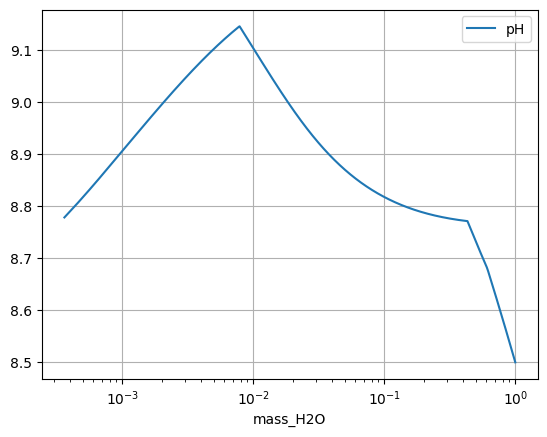

<Figure size 640x480 with 0 Axes>

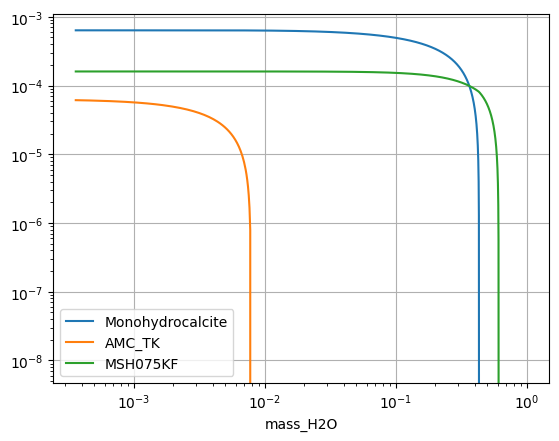

In [55]:
# Construct DataFrame
output = iphreeqc.get_selected_output_array()
header = output[0]
data = output[1:]
df = pd.DataFrame(data, columns=header)

plt.figure()
ph_plot = df.plot(x="mass_H2O", y="pH")
ph_plot.set_xscale('log')
plt.grid(True)

plt.figure()
mineral_plot = df.plot(x="mass_H2O", y=['Monohydrocalcite', 'AMC_TK', 'MSH075KF'])
mineral_plot.set_yscale('log')
mineral_plot.set_xscale('log')
plt.grid(True)


plt.show()